In [3]:
#!pip install torchsummary
torch.cuda.empty_cache()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
#отражение относительно вертикали
tfs_alb_train = A.Compose([
    #Случайно отражаем относительно вертикали (смотрели вправо - смотрим влево)
    A.HorizontalFlip(p = 0.5),
    #Случайно смещаем на 6.25%, затем случайно масштабирует на 10% и случайно поворачиваем на 10 градусов
    A.ShiftScaleRotate(rotate_limit=10),
    #Обрезаем с p=1.0 (неслучайно)
    A.RandomResizedCrop(height=32,width=32, ratio = (0.9, 1.1)),
    #Нормируем по дефолту, он как мы сделали выше кстати!
    A.Normalize(),
    ToTensorV2()
])
tfs_alb_test = A.Compose([
    A.Resize(height=32, width=32),
    #Нормируем по дефолту, он как мы сделали выше кстати!
    A.Normalize(),
    ToTensorV2()
])

#Делаем аугментацию с помощью библиотеки albumentations, она не работает с dataloader, поэтому нужно создать кастомный:
#класс dataset, но сначала загрузим данные:
data_train = torchvision.datasets.CIFAR10(root = 'cifar/train_cifar', train = True, download = True)
data_test = torchvision.datasets.CIFAR10(root = 'cifar/train_cifar', train = False, download = True)

Files already downloaded and verified
Files already downloaded and verified


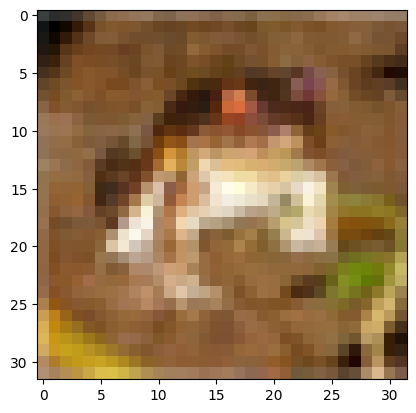

In [6]:
#Так работает трансформация из библиотеки albumentations:
transform = A.Compose([
    A.Resize(height=32,width=32),
    ToTensorV2()
]) 
plt.imshow(transform(image= data_train.data[0])['image'].permute(1,2,0))
plt.show()

In [7]:
#Размер датасета
data_train.data.shape, data_test.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

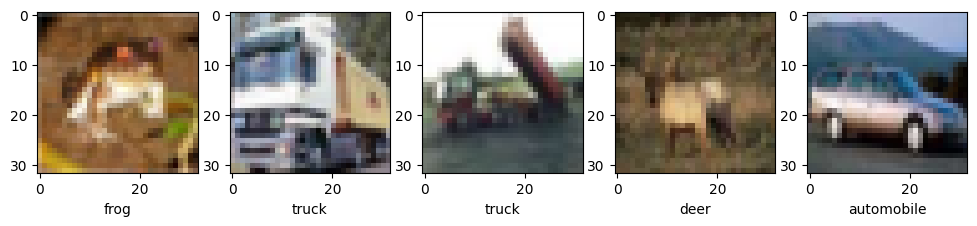

In [8]:
fig, ax = plt.subplots(1,5, figsize = (12,8))
for i, (img, name_img) in enumerate(zip(data_train.data[:5], data_train.targets[:5])):
    ax[i].imshow(img)
    ax[i].set_xlabel(data_train.classes[name_img])

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform = None):
        self.transform = transform
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data[index]
        target = self.target[index]
        
        if self.transform:
            augmentations = self.transform(image = data)
            img = augmentations["image"]                   
        return img, target

In [10]:
train_dataset = MyDataset(data_train.data, data_train.targets, transform = tfs_alb_train)
test_dataset = MyDataset(data_test.data, data_test.targets, transform = tfs_alb_test)

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)

In [12]:
#Скачаем саму модель теперь:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torchvision.models.resnet18(num_classes = 10)
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=(1,1), padding=(1,1), bias=False)
model.maxpool = nn.Identity()
#В размер не входит размер бача:
summary(model, (3,32,32), device = 'cpu')
model.to(device)
None

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─Identity: 1-4                          [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|

In [14]:
loaders = {'train': train_loader, 'test': test_loader}
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0001)
batch_losses = {'train': [], 'test': []}
batch_accuraces = {'train': [], 'test': []}

In [15]:
def fit(model, xb, yb, mode):
    sumL = 0.0
    sumA = 0.0
    
    y = model(xb)
    L = loss(y, yb)
    sumL = L.item()
    sumA = (y.argmax(dim = -1) == yb).float().mean()

    if mode == 'train':
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
    
    return sumL, sumA

In [16]:
def model_training_test(epochs = 12, loaders = loaders, visualize = False, printing = False):
    for epoch in range(epochs):
        for mode, dataloader in loaders.items():
            if mode == 'train':
                model.train()
            else:
                model.eval()
            for i, (xb, yb) in enumerate(dataloader):
                xb = xb.to(device)
                yb = yb.to(device)
                if visualize==True:
                    clear_output(True)
                mean_batch_loss, mean_batch_acc = fit(model, xb, yb, mode)
                if printing == True and i%5==0:
                    print('epohcs = %i, batch = %i, mode = %s, Loss: %.4f, Accuracy: %.4f' 
                          %(epoch, i, mode, mean_batch_loss, mean_batch_acc))
                batch_losses[mode].append(mean_batch_loss)
                batch_accuraces[mode].append(mean_batch_acc.item())
                if visualize==True:
                    plot_()

In [16]:
%%time
##Это обучение!!! 1 эпоха ~ 50сек (GPU T4 x2) (Не трогать, а то придется убивать ядро!)
model_training_test(epochs = 1)

CPU times: user 50.3 s, sys: 932 ms, total: 51.2 s
Wall time: 1min


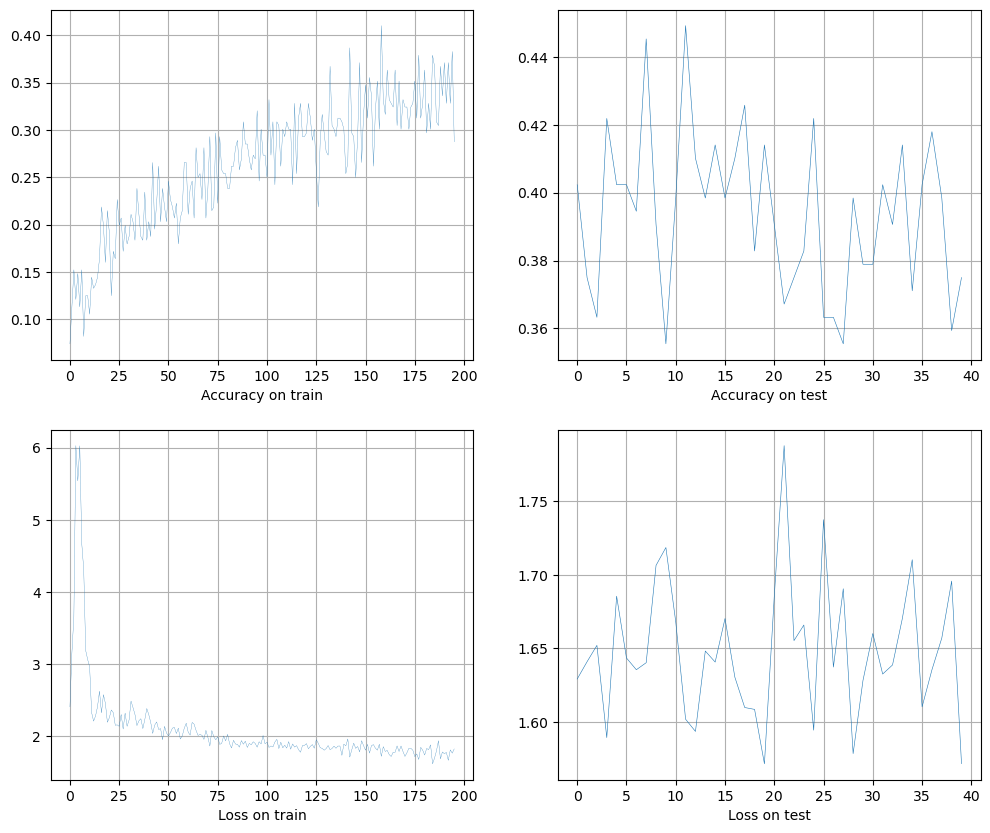

In [17]:
#Лучше тоже не трогать, так как все графики станут пустыми!!!
def plot_():
    fig, ax = plt.subplots(2,2, figsize = (12,10))
    ax[0,0].plot(batch_accuraces['train'], lw = 0.2)
    ax[0,0].set_xlabel('Accuracy on train')
    ax[0,0].grid()
    ax[0,1].plot(batch_accuraces['test'], lw = 0.4)
    ax[0,1].set_xlabel('Accuracy on test')
    ax[0,1].grid()
    ax[1,0].plot(batch_losses['train'], lw = 0.2)
    ax[1,0].set_xlabel('Loss on train')
    ax[1,0].grid()
    ax[1,1].plot(batch_losses['test'], lw = 0.4)
    ax[1,1].set_xlabel('Loss on test')
    ax[1,1].grid()
    plt.show()
    
plot_()

In [18]:
for name, w in model.named_parameters():
    print(w.grad.mean());break;

tensor(0.0003, device='cuda:0')


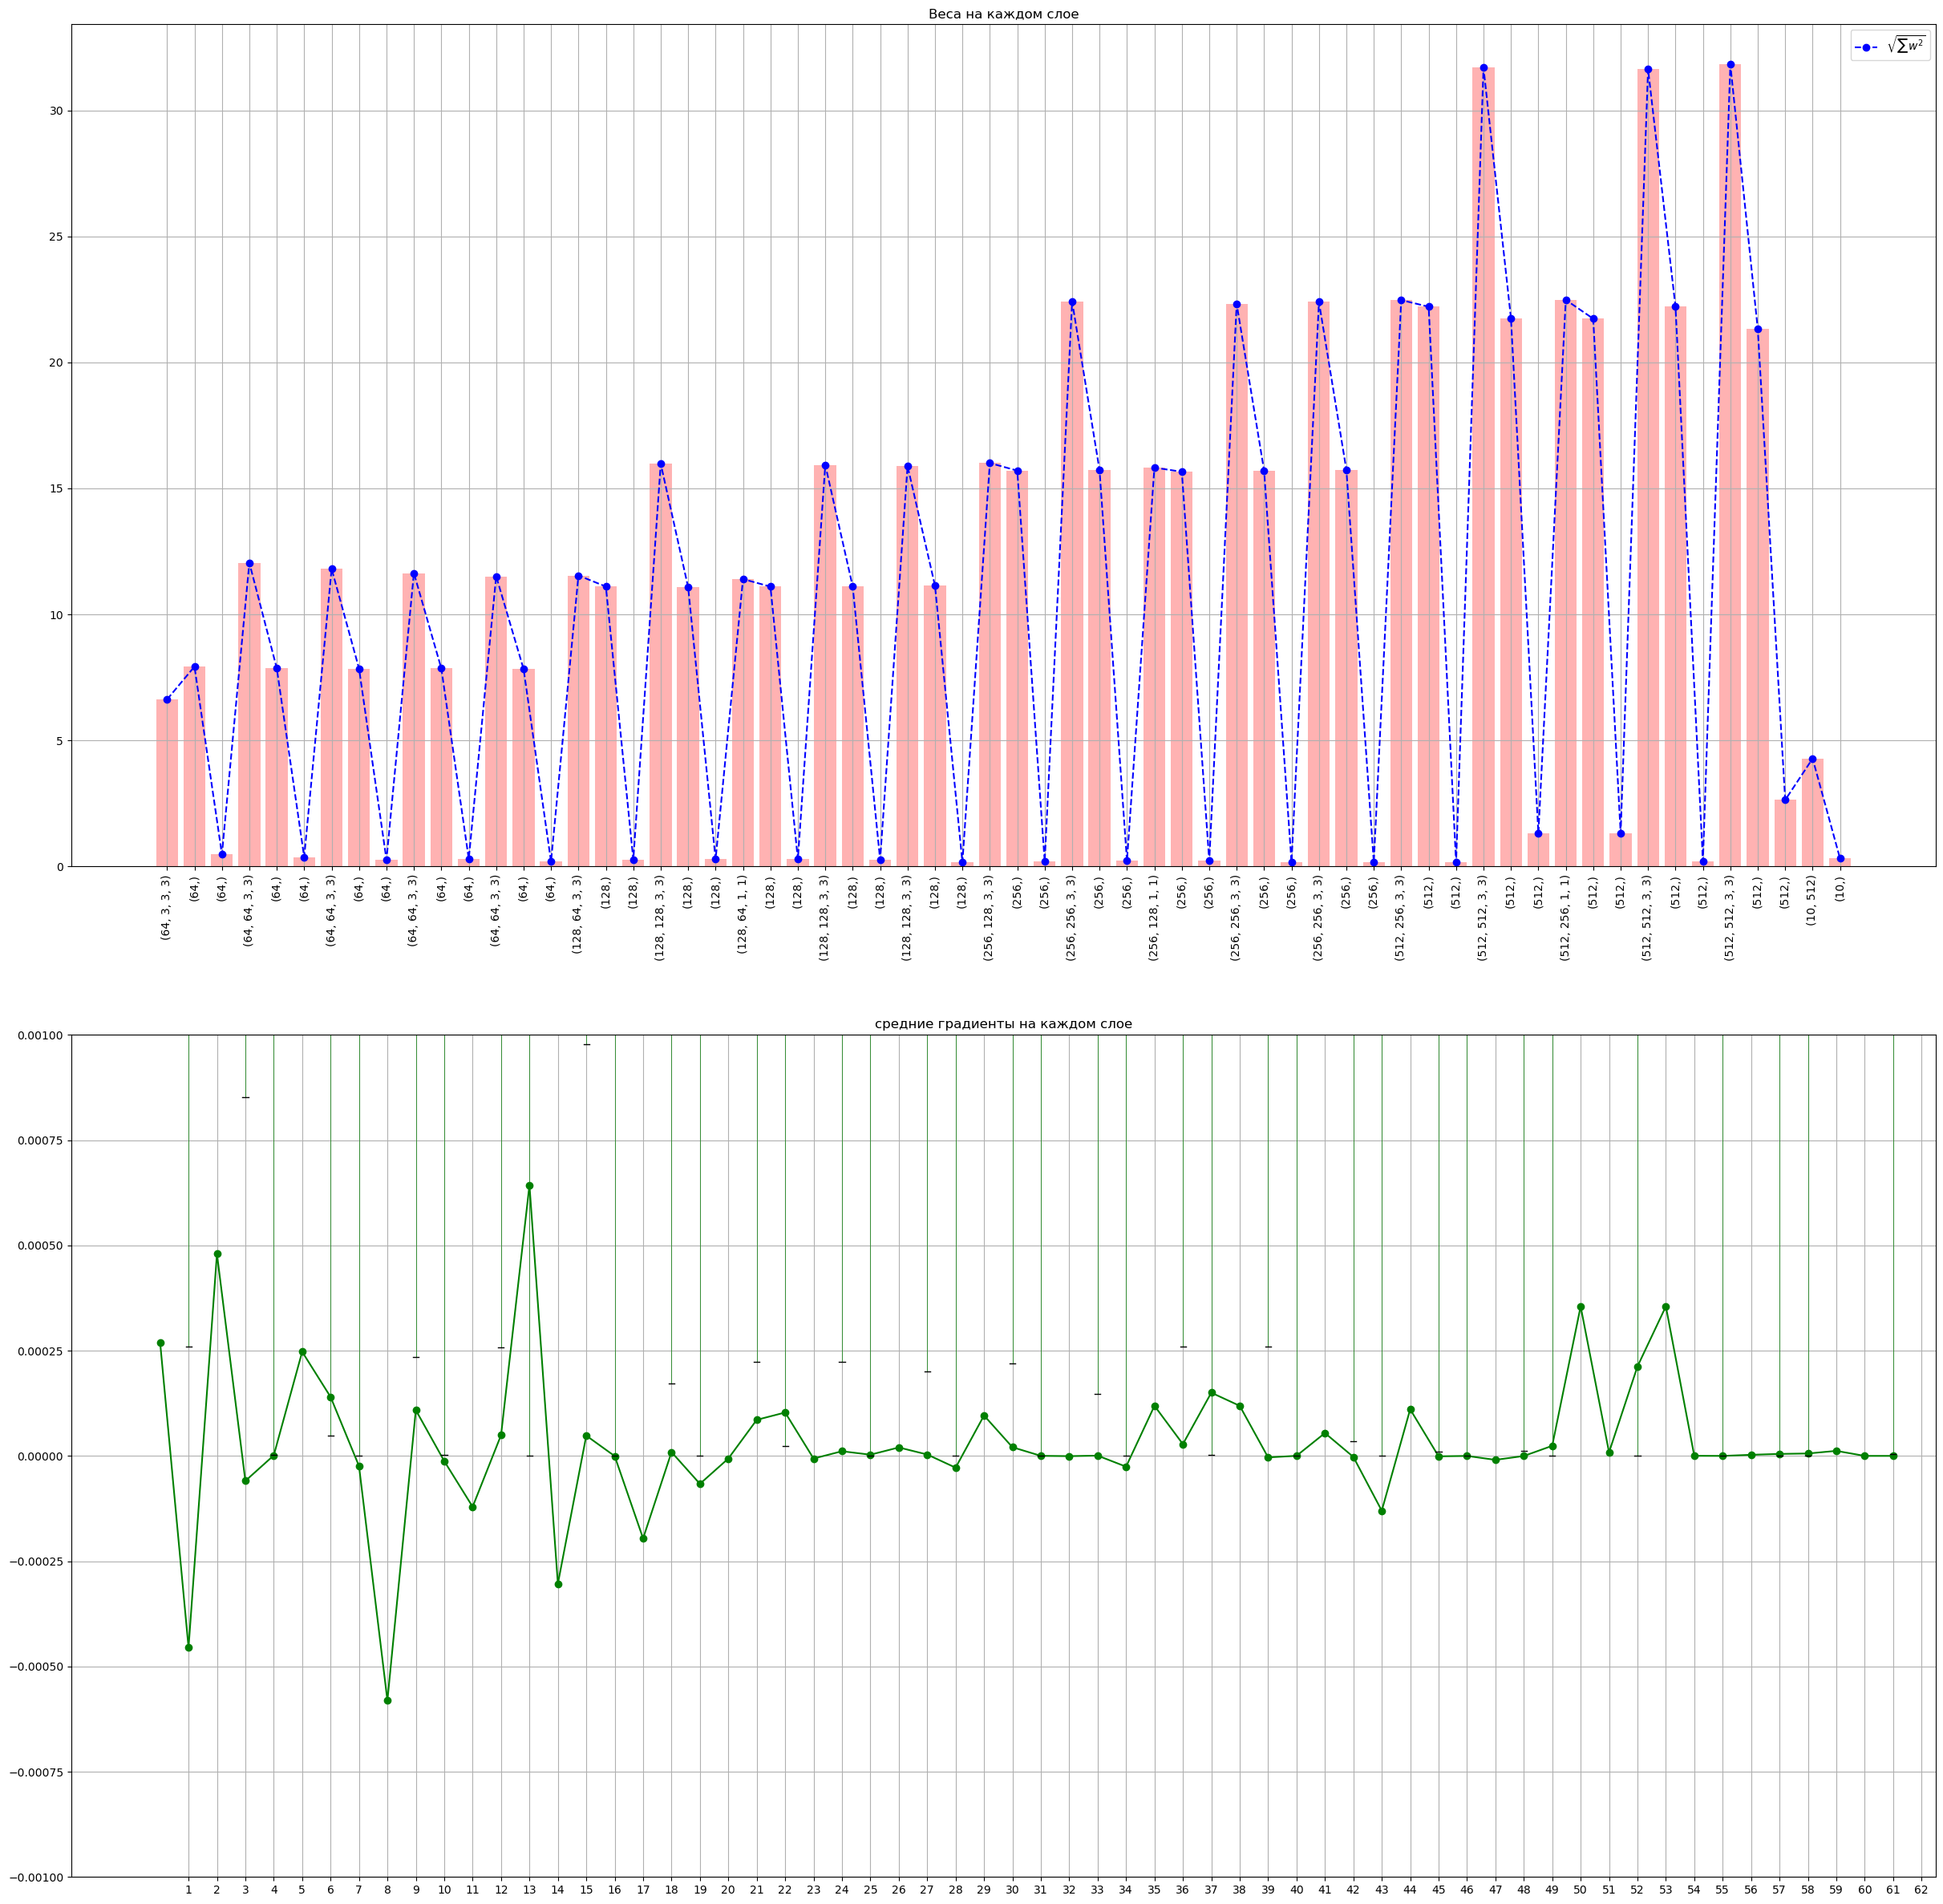

In [30]:
#Посмотрим как ведут себя градиенты на слоях нашей модели (когда она обучалась! не трогать!!!)
def plot_grad_w():
    W_for_layers = []
    grads_for_layers = []
    all_grads_for_layers = []
    number_layer = []
    for name, w in model.named_parameters():
        number_layer.append(tuple(w.shape))
        W_for_layers.append((w*w).sum().item()**(1/2))
        grads_for_layers.append(w.grad.mean().item())
        all_grads_for_layers.append(w.detach().to('cpu').view(-1).abs().numpy())

    fig, ax = plt.subplots(2,1,figsize = (30,30) )
    ax[0].bar(x = range(len(W_for_layers)), height=W_for_layers, alpha = 0.3, color = 'red')
    ax[0].plot(W_for_layers, '--', color = 'blue', marker = 'o', label = '$\sqrt{\sum w^2} $')
    ax[0].set_xticks(ticks = range(len(W_for_layers)), labels = number_layer, rotation = 90)
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title('Веса на каждом слое')
    ax[1].plot(grads_for_layers, '-', color = 'green', marker = 'o', label = '$\sqrt{\sum w^2} $')
    ax[1].boxplot(all_grads_for_layers, widths=0.4, sym="o", boxprops = dict(color="b", alpha=0.9, linestyle="dashdot", linewidth = 0.5),
            whiskerprops = dict(color="green", alpha=0.7, linewidth = 0.7),showfliers = False)
    ax[1].set_ylim((-1e-3, 1e-3))
    ax[1].set_title('средние градиенты на каждом слое')
    ax[1].grid()
    plt.show()
    
plot_grad_w()

In [17]:
#Сохраним модель нашу:
import datetime
  
state = {'info':      "ResNet - CIFAR-10, 10 epochs",          # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
 
torch.save(state, 'ResNet_10epochs.pt')                    # сохраняем файл

## <center> Отсюда начинаем тестирование!!!

In [18]:
state = torch.load('ResNet_10epochs.pt', 
                   map_location = torch.device('cpu'))                   
model.load_state_dict(state['model'])                # получаем параметры модели
optimizer.load_state_dict(state['optimizer'])    # получаем состояние оптимизатора
 
print(state['info'], state['date'])              # вспомогательная информация

ResNet - CIFAR-10, 10 epochs 2023-07-15 17:31:00.312521


In [23]:
%%time
#Будем тестировать загруженную модель с анимацией скоров и лосов:
loader_for_test = {'test' : test_loader}
model_training_test(epochs = 1, loaders = loader_for_test, printing=True)

epohcs = 0, batch = 0, mode = test, Loss: 0.6342, Accuracy: 0.7773
epohcs = 0, batch = 5, mode = test, Loss: 0.5354, Accuracy: 0.8125
epohcs = 0, batch = 10, mode = test, Loss: 0.6582, Accuracy: 0.7773
epohcs = 0, batch = 15, mode = test, Loss: 0.4983, Accuracy: 0.8320
epohcs = 0, batch = 20, mode = test, Loss: 0.6717, Accuracy: 0.7812
epohcs = 0, batch = 25, mode = test, Loss: 0.7281, Accuracy: 0.7617
epohcs = 0, batch = 30, mode = test, Loss: 0.7200, Accuracy: 0.7617
epohcs = 0, batch = 35, mode = test, Loss: 0.5866, Accuracy: 0.8047
CPU times: total: 29.2 s
Wall time: 33.9 s
